# Learning Rates
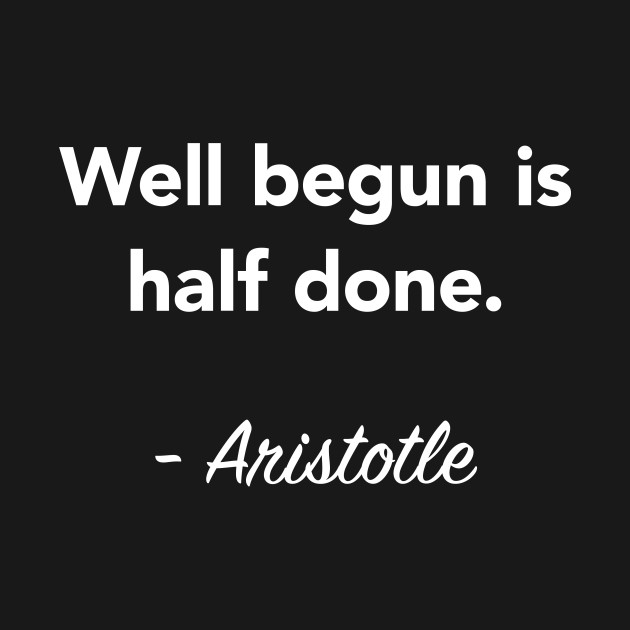

# Setup

In [8]:
pip install keras-one-cycle-lr

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from IPython.display import Image

# Data
* CIFAR-10 (http://github.com/EN10/CIFAR)
* 60,000 32 x 32 color images 
* 10 Labeled classes

In [18]:
cifar10 = keras.datasets.cifar10.load_data()

In [19]:
(X_train, y_train), (X_test, y_test) = cifar10

In [20]:
print(f'Training Images {X_train.shape}, Labels {y_train.shape}')
print(f'Testing  Images {X_test.shape}, Labels {y_test.shape}')

Training Images (50000, 32, 32, 3), Labels (50000, 1)
Testing  Images (10000, 32, 32, 3), Labels (10000, 1)


In [21]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

X_train /= 255
X_test  /= 255

In [22]:
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

In [40]:
class_names = [
    'car',
    'plane',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

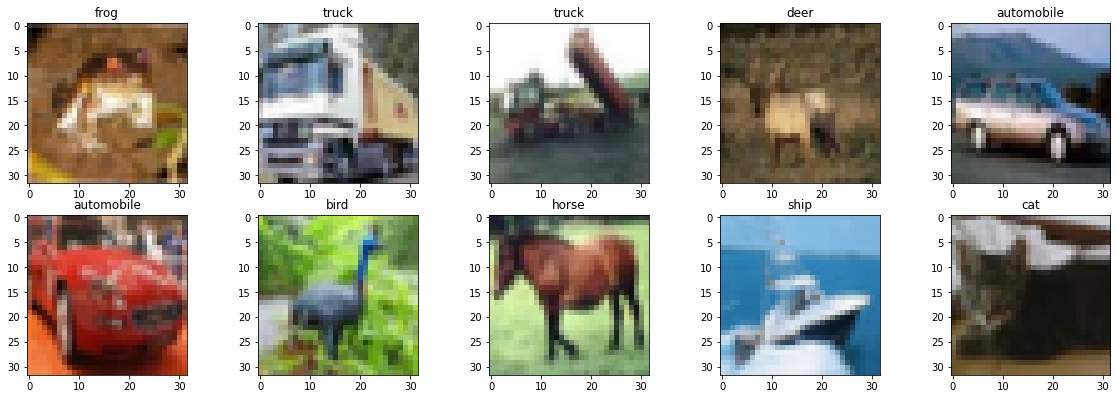

In [28]:
plt.figure(figsize=(20,10))
cols = 5
for i, image in enumerate(X_train[0:10, :]):
    plt.subplot(10 / cols + 1, cols, i + 1)
    plt.imshow(image.squeeze())
    plt.title(class_names[y_train[i].argmax()]);

# Learning Plots

In [41]:
def plot_performance(history, color='b'):
    fig, ax = plt.subplots(figsize=(12,10))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [291]:
def compare_history(histories):
    colors = (c for c in ['blue', 'orange', 'green', 'black', 'red', 'purple'])
    fig, ax = plt.subplots(figsize=(12,10))
    
    ax = plt.subplot(2, 1, 1)
    for key, history in histories.items():
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(val_acc) + 1)
        plt.plot(epochs, val_acc, 'b', label=key, color=next(colors))   
        plt.title('Validation Accuracy')
        plt.ylabel('Accuracy')
    ax.legend()
    
    plt.show();

In [43]:
def plot_confusion(test, pred):
    cm = confusion_matrix(test, pred)
    df = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize=(10, 10))
    sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

# Model
* Use a ConvNet, Relu Activations, Adam Optimizer

In [106]:
def create_model():
    input_shape = (32, 32, 3)
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(12, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

In [4]:
Image(url="https://i.stack.imgur.com/POQ2J.png")

In [3]:
Image(url="https://miro.medium.com/max/679/1*-KbwNtZYpJcUQs8yoRGgkQ.jpeg")

# Parameters

In [ ]:
batch_size = 64
epochs = 20

# Baseline

## Model

In [130]:
model = create_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_8 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
________________________________________________

In [131]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [132]:
history_default = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 16s 313us/sample - loss: 1.5970 - accuracy: 0.4188 - val_loss: 1.4146 - val_accuracy: 0.4862
Epoch 2/20
50000/50000 [==============================] - 18s 355us/sample - loss: 1.3424 - accuracy: 0.5196 - val_loss: 1.3170 - val_accuracy: 0.5361
Epoch 3/20
50000/50000 [==============================] - 15s 303us/sample - loss: 1.2349 - accuracy: 0.5608 - val_loss: 1.2632 - val_accuracy: 0.5511
Epoch 4/20
50000/50000 [==============================] - 16s 318us/sample - loss: 1.1602 - accuracy: 0.5867 - val_loss: 1.2074 - val_accuracy: 0.5736
Epoch 5/20
50000/50000 [==============================] - 15s 301us/sample - loss: 1.1044 - accuracy: 0.6099 - val_loss: 1.1905 - val_accuracy: 0.5742
Epoch 6/20
50000/50000 [==============================] - 17s 337us/sample - loss: 1.0499 - accuracy: 0.6288 - val_loss: 1.1887 - val_accuracy: 0.5821
Epoch 7/20
50000/50000 [====================

## Diagnostics

In [133]:
pred = model.predict_classes(X_test)
print(model.evaluate(X_test, y_test))

10000/10000 [==============================] - 1s 78us/sample - loss: 1.5345 - accuracy: 0.5756
[1.534534760093689, 0.5756]


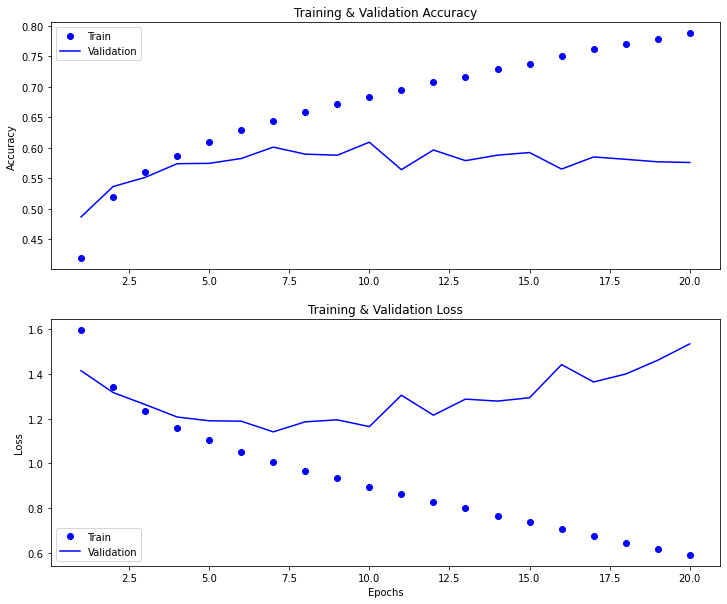

In [134]:
plot_performance(history_default)

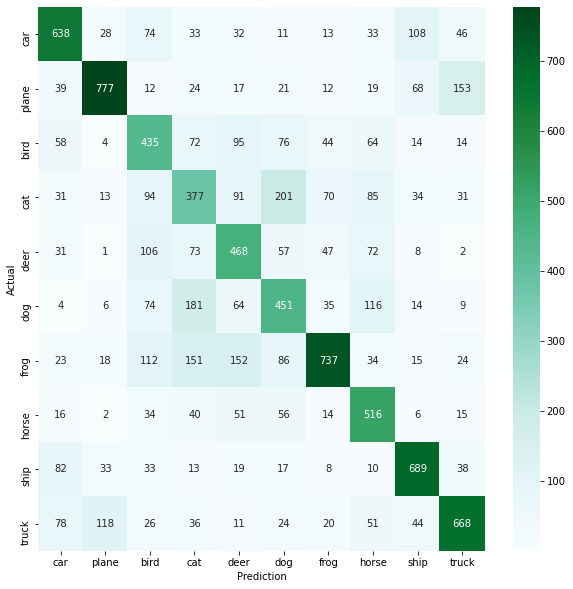

In [135]:
plot_confusion(pred, y_test.argmax(-1))

# Scheduler
* Intuition
    * We should take large steps when we begin training
    * We should take smaller steps as we get closer to the minimum
* Keras has several implementations
    * Exponential Decay
    * Inverse Time Decay
    * Piecewise Constant Decay
    * Polynomial Decay

## Model

In [163]:
model = create_model()
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_15 (Flatten)         (None, 1200)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
_______________________________________________

In [164]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [165]:
learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-3 if epoch < 10 else 1e-4, verbose=1)

history_schedule = model.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      validation_data=(X_test, y_test),
                      shuffle=True,
                      callbacks=[learning_rate_schedule])

Train on 50000 samples, validate on 10000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
50000/50000 [==============================] - 15s 305us/sample - loss: 1.5509 - accuracy: 0.4371 - val_loss: 1.4229 - val_accuracy: 0.4973

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
50000/50000 [==============================] - 15s 299us/sample - loss: 1.2865 - accuracy: 0.5457 - val_loss: 1.2825 - val_accuracy: 0.5479

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/20
50000/50000 [==============================] - 15s 291us/sample - loss: 1.1755 - accuracy: 0.5861 - val_loss: 1.1990 - val_accuracy: 0.5732

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/20
50000/50000 [==============================] - 16s 313us/sample - loss: 1.1087 - accuracy: 0.6111 - val_loss: 1.1911 - val_accuracy: 0.5835

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
E

## Diagnostics

In [166]:
pred = model.predict_classes(X_test)
print(model.evaluate(X_test, y_test))

10000/10000 [==============================] - 1s 77us/sample - loss: 1.1968 - accuracy: 0.6209
[1.1967778451919555, 0.6209]


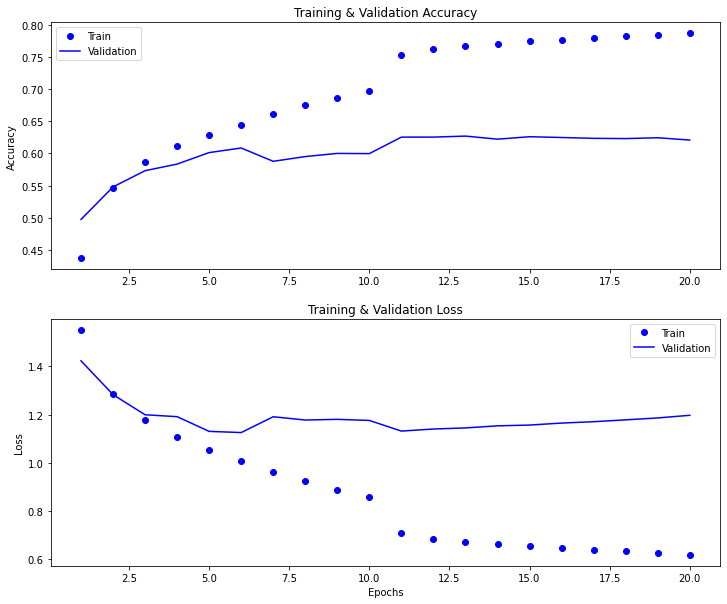

In [167]:
plot_performance(history_schedule)

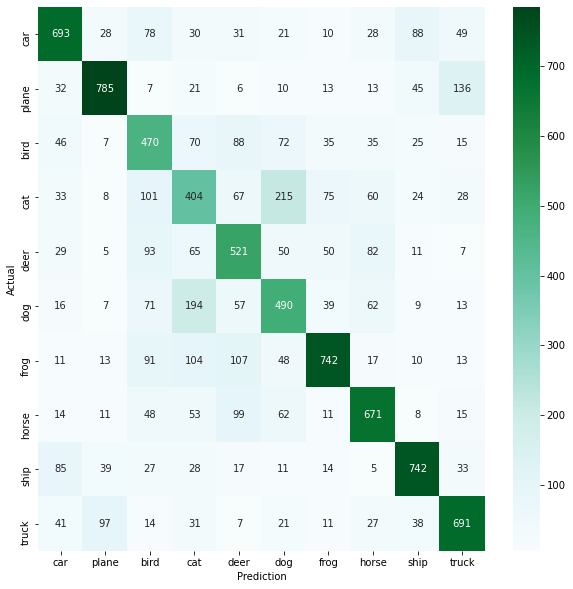

In [168]:
plot_confusion(pred, y_test.argmax(-1))

## Comparison

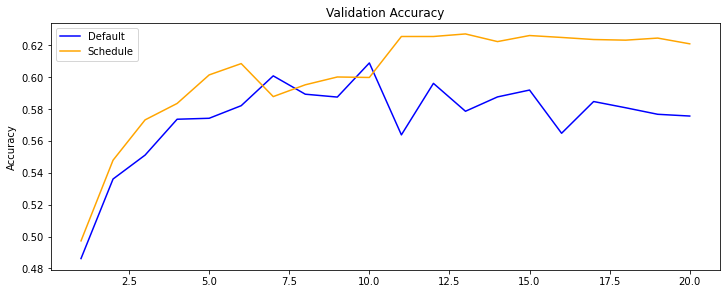

In [292]:
compare_history({'Default': history_default, 
                 'Schedule': history_schedule})

# Plateau 
* With Plateau we train util progress stops
* We then reduce our learning rate and continue

## Model

In [147]:
model = create_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_11 (Flatten)         (None, 1200)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
_______________________________________________

In [148]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [149]:
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.5, 
                                         patience=2, 
                                         verbose=1)

history_plateau = model.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      validation_data=(X_test, y_test),
                      shuffle=True,
                      callbacks=[reduce_learning_rate])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 16s 322us/sample - loss: 1.6154 - accuracy: 0.4172 - val_loss: 1.4373 - val_accuracy: 0.4805
Epoch 2/20
50000/50000 [==============================] - 18s 350us/sample - loss: 1.3709 - accuracy: 0.5121 - val_loss: 1.3941 - val_accuracy: 0.5143
Epoch 3/20
50000/50000 [==============================] - 17s 338us/sample - loss: 1.2659 - accuracy: 0.5485 - val_loss: 1.2876 - val_accuracy: 0.5417
Epoch 4/20
50000/50000 [==============================] - 16s 311us/sample - loss: 1.1929 - accuracy: 0.5762 - val_loss: 1.2109 - val_accuracy: 0.5721
Epoch 5/20
50000/50000 [==============================] - 16s 317us/sample - loss: 1.1415 - accuracy: 0.5917 - val_loss: 1.2246 - val_accuracy: 0.5660
Epoch 6/20
50000/50000 [==============================] - 15s 305us/sample - loss: 1.0915 - accuracy: 0.6124 - val_loss: 1.2087 - val_accuracy: 0.5753
Epoch 7/20
50000/50000 [====================

## Diagnostics

In [150]:
pred = model.predict_classes(X_test)
print(model.evaluate(X_test, y_test))

10000/10000 [==============================] - 1s 78us/sample - loss: 1.2365 - accuracy: 0.6011
[1.2364720737457275, 0.6011]


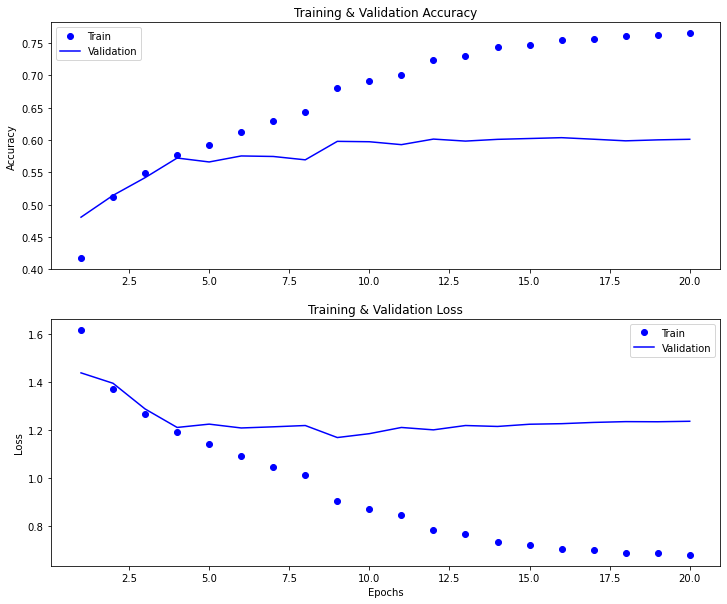

In [151]:
plot_performance(history_plateau)

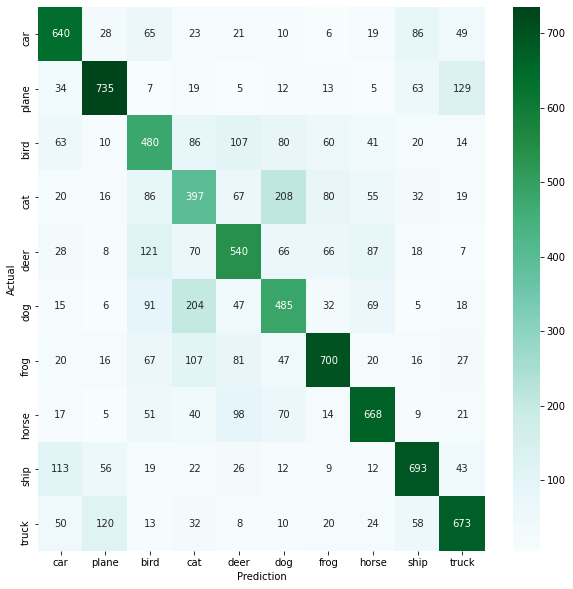

In [152]:
plot_confusion(pred, y_test.argmax(-1))

## Comparison

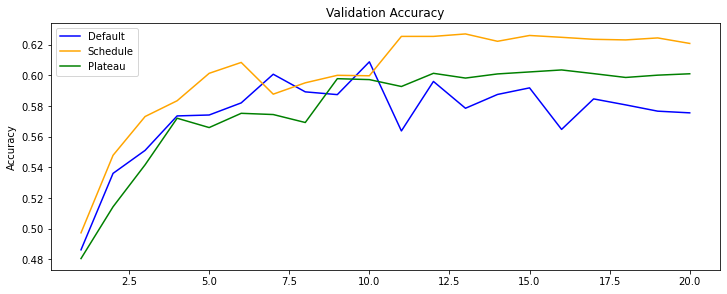

In [293]:
compare_history({'Default': history_default, 
                 'Schedule': history_schedule, 
                 'Plateau': history_plateau})

# Learning Rate Finder
* Implemented by Pavel Surmenok 
    * http://github.com/surmenok/keras_lr_finder
    * Adjusted for tensorflow 2.1
    * Adjusted graphing
    * Fix to get_best_lr
* A disciplined approach to neural network hyper-parameters (https://arxiv.org/abs/1803.09820)

In [251]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            print(' Stopping')
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log', marker=None):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.figure(figsize=(8,6))
        if marker is not None:
            plt.axvline(x=marker, color='red')
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01), marker=None):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.figure(figsize=(8,6))
        if marker is not None:
            plt.axvline(x=marker, color='red')
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

## Find Best LR

In [252]:
model = create_model()

In [253]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [254]:
lr_finder = LRFinder(model)    
lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=1.0, batch_size=512, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 9s 179us/sample - loss: 2.3261 - accuracy: 0.1026
Epoch 2/5
50000/50000 [==============================] - 9s 176us/sample - loss: 2.2578 - accuracy: 0.1523
Epoch 3/5
50000/50000 [==============================] - 9s 178us/sample - loss: 1.7726 - accuracy: 0.3579
Epoch 4/5
32768/50000 [==================>...........] - ETA: 3s - loss: 1.8397 - accuracy: 0.3604

In [278]:
best = lr_finder.get_best_lr(sma=20, n_skip_beginning=50, n_skip_end=50)
best

0.005287669

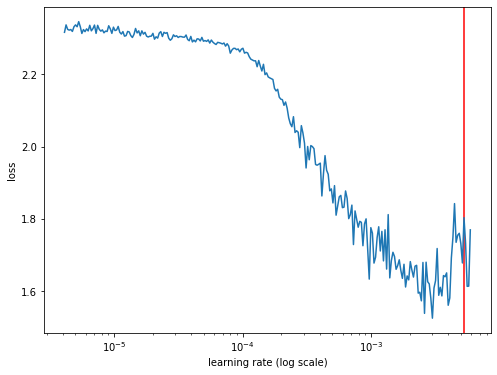

In [279]:
lr_finder.plot_loss(n_skip_beginning=50, n_skip_end=50, marker=best)

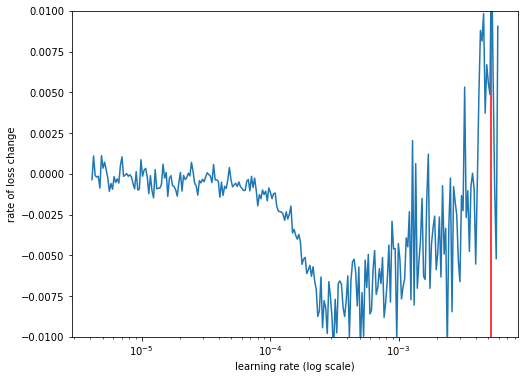

In [280]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=50, n_skip_end=50, marker=best)

## Model

In [281]:
model = create_model()
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_27 (Flatten)         (None, 1200)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_55 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
_______________________________________________

In [282]:
model.compile(optimizer=Adam(learning_rate=best), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [283]:
history_best = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 17s 338us/sample - loss: 1.8332 - accuracy: 0.3310 - val_loss: 1.7730 - val_accuracy: 0.3621
Epoch 2/20
50000/50000 [==============================] - 18s 351us/sample - loss: 1.6174 - accuracy: 0.4202 - val_loss: 1.7669 - val_accuracy: 0.3794
Epoch 3/20
50000/50000 [==============================] - 18s 354us/sample - loss: 1.5472 - accuracy: 0.4488 - val_loss: 1.5650 - val_accuracy: 0.4455
Epoch 4/20
50000/50000 [==============================] - 18s 353us/sample - loss: 1.5020 - accuracy: 0.4668 - val_loss: 1.6003 - val_accuracy: 0.4357
Epoch 5/20
50000/50000 [==============================] - 17s 340us/sample - loss: 1.4565 - accuracy: 0.4859 - val_loss: 1.5541 - val_accuracy: 0.4468
Epoch 6/20
50000/50000 [==============================] - 17s 332us/sample - loss: 1.4128 - accuracy: 0.4993 - val_loss: 1.5553 - val_accuracy: 0.4670
Epoch 7/20
50000/50000 [====================

## Diagnostics

In [284]:
pred = model.predict_classes(X_test)
print(model.evaluate(X_test, y_test))

10000/10000 [==============================] - 1s 78us/sample - loss: 1.8364 - accuracy: 0.4261
[1.8364132572174072, 0.4261]


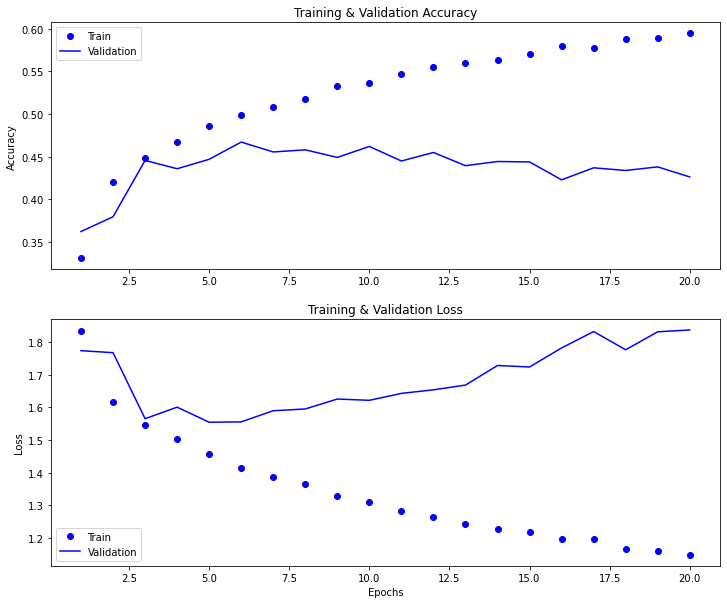

In [285]:
plot_performance(history_best)

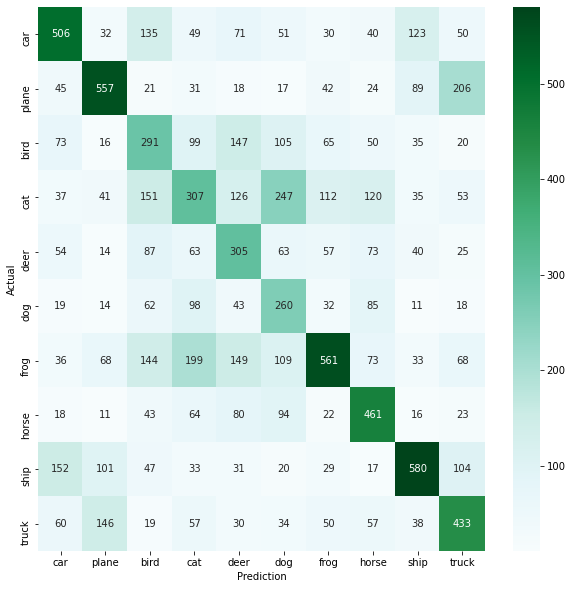

In [286]:
plot_confusion(pred, y_test.argmax(-1))

## Comparison

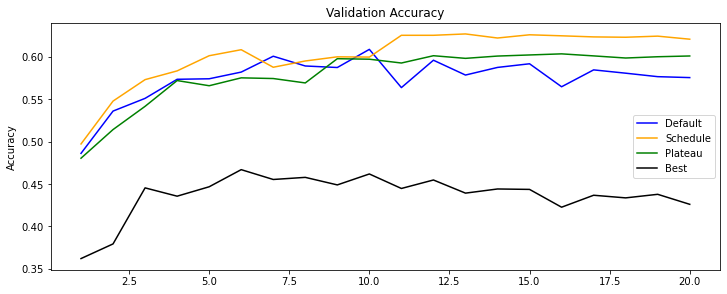

In [294]:
compare_history({'Default': history_default, 
                 'Schedule': history_schedule, 
                 'Plateau': history_plateau,
                 'Best': history_best})

# Karpathy Tweet

In [63]:
Image(url='https://pbs.twimg.com/media/DXdvgY_WAAYuPKn?format=jpg&name=900x900')

## Model

In [120]:
model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
________________________________________________

In [121]:
model.compile(optimizer=Adam(learning_rate=3e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [122]:
history_karpathy = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 17s 338us/sample - loss: 1.7153 - accuracy: 0.3841 - val_loss: 1.5220 - val_accuracy: 0.4582
Epoch 2/20
50000/50000 [==============================] - 19s 372us/sample - loss: 1.4391 - accuracy: 0.4872 - val_loss: 1.3870 - val_accuracy: 0.5060
Epoch 3/20
50000/50000 [==============================] - 16s 314us/sample - loss: 1.3369 - accuracy: 0.5265 - val_loss: 1.3009 - val_accuracy: 0.5367
Epoch 4/20
50000/50000 [==============================] - 15s 305us/sample - loss: 1.2747 - accuracy: 0.5500 - val_loss: 1.2763 - val_accuracy: 0.5522
Epoch 5/20
50000/50000 [==============================] - 17s 334us/sample - loss: 1.2217 - accuracy: 0.5678 - val_loss: 1.2705 - val_accuracy: 0.5515
Epoch 6/20
50000/50000 [==============================] - 17s 338us/sample - loss: 1.1758 - accuracy: 0.5879 - val_loss: 1.2007 - val_accuracy: 0.5704
Epoch 7/20
50000/50000 [====================

## Diagnostics

In [127]:
pred = model.predict_classes(X_test)
print(model.evaluate(X_test, y_test))

10000/10000 [==============================] - 1s 79us/sample - loss: 1.1126 - accuracy: 0.6184
[1.112565164756775, 0.6184]


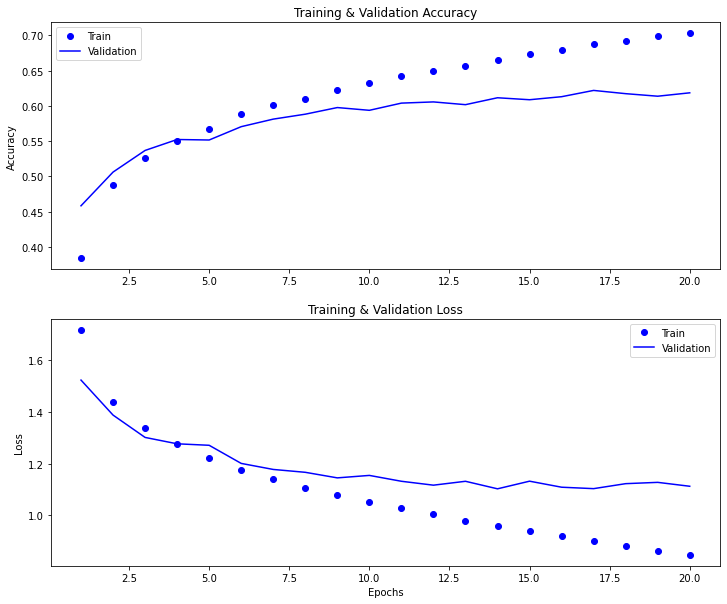

In [128]:
plot_performance(history_karpathy)

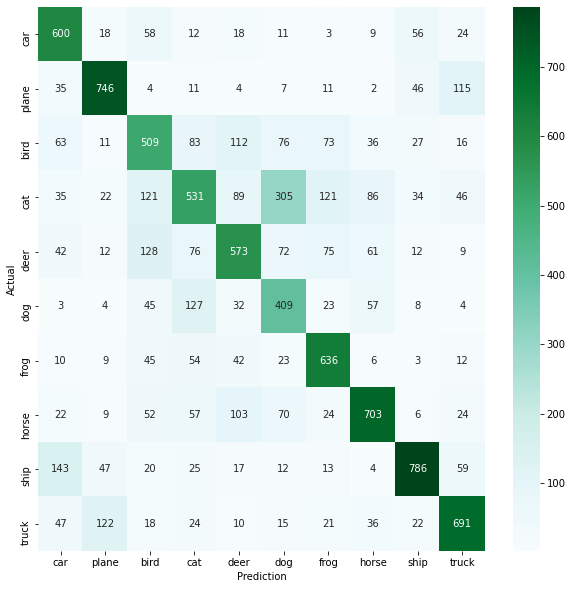

In [129]:
plot_confusion(pred, y_test.argmax(-1))

## Comparison

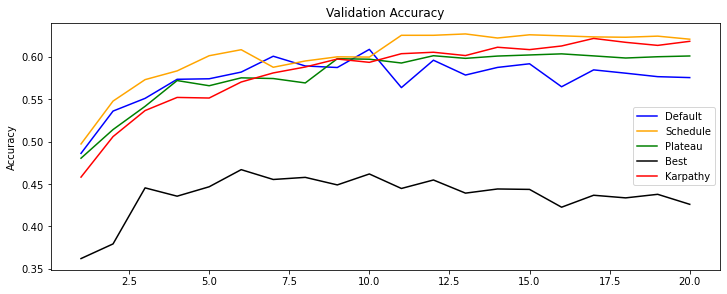

In [295]:
compare_history({'Default': history_default,
                 'Schedule': history_schedule,
                 'Plateau': history_plateau,
                 'Best': history_best,
                 'Karpathy': history_karpathy})

## Rate Finder

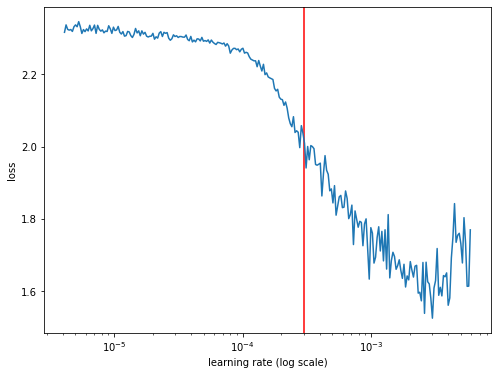

In [288]:
lr_finder.plot_loss(n_skip_beginning=50, n_skip_end=50, marker=3e-4)

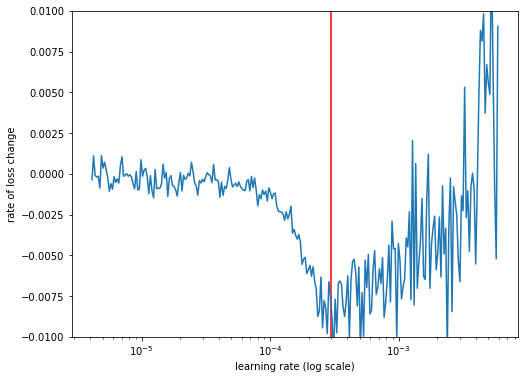

In [289]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=50, n_skip_end=50, marker=3e-4)

# Insights
* Learning Rates
    * Too high - you step over the minimum and fail to learn
    * Too small - it takes many epochs (time and resources) to learn
* Improvements
    * Rate schedules - finicky to pick a good schedule
    * Rate plateau - improvement, take smaller steps if you stop learning 
* Good Learning Rate
    * Learning Rate finder - challenge to read / interpret plots
* Heuristic Approaches
    * Rate Finder
        * Learning Rate finder to get good initial value
        * Drop on Plateau / Schedule to go further
    * Watch Learning Rate
        * Training slowly increase magnitude
        * Not learning decrease magnitude
        * Add in scheduling to learn quickly and apporach minimum
    * One Cycle Learning (Future Notebook)
* Higher Accuracy on CIFAR
    * We have 60,000 Images (We could do augmentation to improve)
    * Increase network capacity (more layers, more filters)
        * In this example, we have a Conv2D 5x5 -> MaxPool -> Conv2D 5x5 *
        * We should achieve 75-80% with 4-5 Blocks of Conv2D 3x3 -> MaxPool (32 - 64 Filters)
    * Leverage a pre-trained network

